In [ ]:
!pip install graphviz

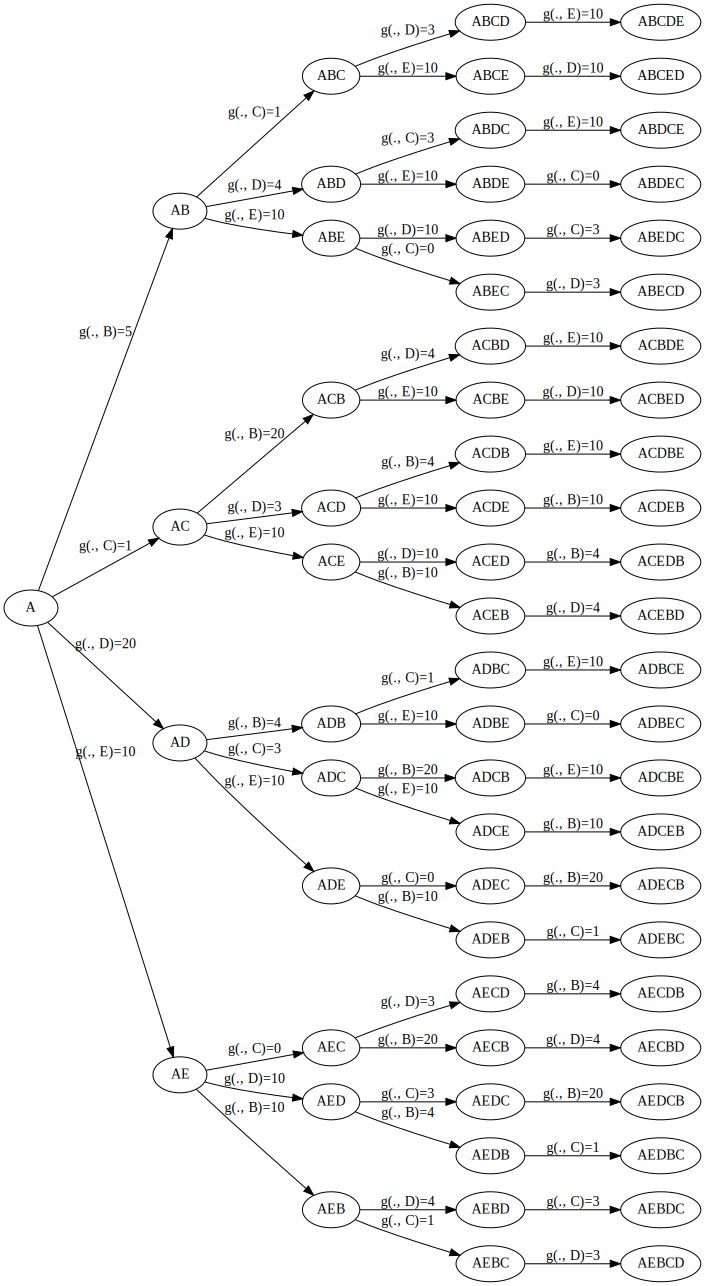

Optimal controls in order: ['B', 'D', 'E', 'C']  at cost  20


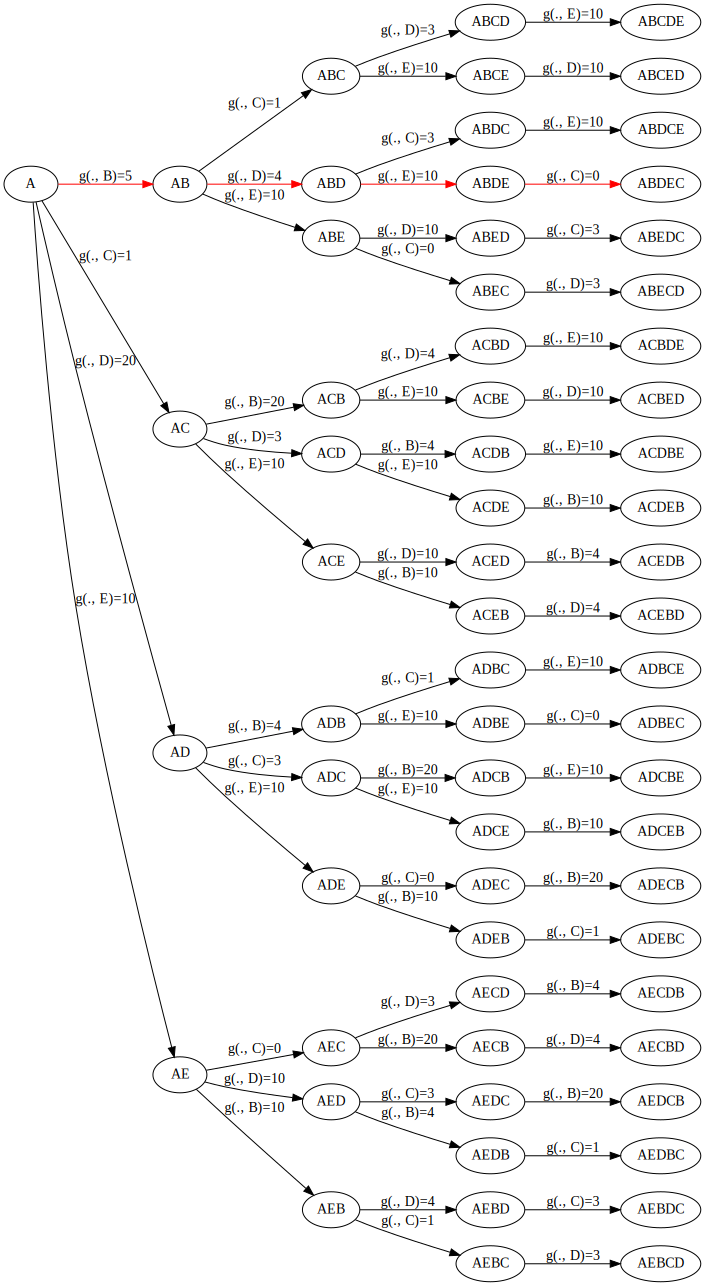

In [1]:
"""
Solves Problem 1.1(a) of Bertsekas RL Book using exact Dynamic programming.

Authors: Vikas Dhiman and Ata Turgut
"""
import math
from functools import partial

def depth_first_build_graph(
        k,
        xk,  # start state,
        Us,  # Possible control sets Uk per stage, so that uk ∈ Uk
        gs,  # Stage costs gk
        fs,  # system dynamics fk(x, u) that predicts next state
        graph_adj_list # graph to be built as adjacency list
        ):
    assert len(Us) == len(gs) == len(fs)

    N = len(gs)
    if k >= N:
        return

    graph_adj_list.setdefault(k, {})
    graph_adj_list[k].setdefault(xk, [])
    for u in Us[k](xk):
        xkp1 = fs[k](xk, u)
        cost = gs[k](xk, u)
        # append all the information you might need
        # neighbor, cost of this edge, control of this edge, and the parent
        graph_adj_list[k][xk].append((xkp1, cost, u, xk))
        depth_first_build_graph(k+1, xkp1, Us, gs, fs, graph_adj_list)
        
def generate_graphviz_graph(graph_adj_list, optpath=None):
    """
    Generate graphviz graph  for visualization
    """
    import graphviz
    dot = graphviz.Digraph('travelling-salesman', strict=True,
                           graph_attr=dict(rankdir='LR'),
                           comment='Travelling salesman graph')
    for k, adj in graph_adj_list.items():
        for xk, nbrs in adj.items():
            dot.node(xk, xk)
            for xkp1, cost, u, xk in nbrs:
                dot.node(xkp1)
                if xkp1 != "A":
                    if optpath is not None and (optpath[k] == xk and optpath[k+1]  == xkp1):
                        color ='red'
                        weight = '5'
                    else:
                        color= 'black'
                        weight = '1'
                    dot.edge(xk, xkp1, label=f"g(., {u})={cost}", color=color, weight=weight)
    dot.graph_attr['rankdir'] = 'LR'
    #print(dot.source)
    return dot

def visualize_graph(dot):
    from IPython.display import display
    display(dot)

def exactdp(graph_adj_list, # graph
            x0,  # start state,
            Us,  # Possible control sets Uk per stage, so that uk ∈ Uk
            gs,  # Stage costs gk
            fs,  # system dynamics fk(x, u) that predicts next state
            N    # Number of stages
            ):


    COSTIDX = 1
    X_T_PLUS_1_IDX = 0
    JN = {}
    for xN in graph_adj_list[N-1].keys():
        # there should be only one neighbor of the last state
        assert len(graph_adj_list[N-1][xN]) == 1, \
            (len(graph_adj_list),graph_adj_list[N-1],graph_adj_list[N-1][xN])
        JN[xN] = graph_adj_list[N-1][xN][0][COSTIDX]

    # Go over the directed graph backwards to apply the minimum cost-to-go
    # equation
    Js_reversed = [JN] # cost to go
    pis_reversed = [] # policy
    Js = []*N
    for k in range(N-2, -1, -1):
        Jkp1 = Js_reversed[-1] # pick the last J
        Jk = {} # Find the cost to go for each state
        pik = {} # policy
        # The number of states you branchout 
        for xk, nbrs in graph_adj_list[k].items():
            # +++++++++++++Start of Dynamic programming equation +++++++++
            # Jk = min_u g(x, u)  + Jk+1(next_state)
            min_xkp1, min_cost, min_u, min_xkrecalled = min(
                nbrs, 
                default=math.inf,
                key=lambda nbr: nbr[COSTIDX] + Jkp1[nbr[X_T_PLUS_1_IDX]])
            # +++++++++++++End of Dynamic programming equation +++++++++
            assert min_xkrecalled == xk # should be the same
            Jk[xk] = min_cost + Jkp1[min_xkp1]
            pik[xk] = min_u
        Js_reversed.append(Jk)
        pis_reversed.append(pik)
    # Construct the min cost list of actions
    pis = list(reversed(pis_reversed))
    xk = x0
    us = []
    optpath =  []
    for k in range(N-1):
        uk = pis[k][xk]
        xkp1 = fs[k](xk, uk)
        us.append(uk)
        optpath.append(xk)
        xk = xkp1
    optpath.append(xk)
    return us, Js_reversed[-1][x0], optpath

def next_state(allcities, xk, u):
    """
    f(xk, u) : system dynamics/ transition function
    """
    if len(xk) == len(allcities):
        return "A"
    else:
        return xk + u

def get_cost(travelling_costs, name2idx, xk, u):
    """
    g(xk, u): cost function
    """
    lastcity = xk[-1]
    lastcityidx = name2idx[lastcity]
    nextcity = u
    nextcityidx = name2idx[nextcity]
    return travelling_costs[lastcityidx][nextcityidx]

def remaining_controls(allcities, terminalcity, xk):
    """
    Uk(xk):  Remaining possible controlls at xk
    """
    # Find the possible cities that can be visited given that the state is xk
    if len(allcities) == len(xk): # visited all cities
        return terminalcity
    # Use Python setminus
    # https://docs.python.org/3/library/stdtypes.html#set.difference
    return list(set(allcities) - set(xk)) # return it as list

def make_travelling_salesman_problem():
    # all cities
    allcities = "ABCDE"
    # City names
    name2idx = dict(zip("ABCDE", [0, 1, 2, 3, 4]))
    # City travel matrix
    travelling_costs = [
            [0, 5, 1, 20, 10],
             [20, 0, 1, 4, 10],
             [1, 20, 0, 3, 10],
             [18, 4, 3, 0, 10],
             [30, 10, 0, 10, 0]
             ]
    N = 5
    x0 = "A"
    terminalcity = "A"
    Us = [partial(remaining_controls, allcities, terminalcity)]*(N)
    gs = [partial(get_cost, travelling_costs, name2idx)]*(N)
    fs = [partial(next_state, allcities)]*(N)
    
    # forward pass to get all states as a directed graph.
    # We are going to represent graphs as adjacency lists
    k = 0
    graph_adj_list = {0 : {x0: []}}
    depth_first_build_graph(
        k,
        x0,
        Us,
        gs,
        fs,
        graph_adj_list)
    visualize_graph(generate_graphviz_graph(graph_adj_list))
    
    us, J0_x0, optpath = exactdp(
            graph_adj_list, # graph
            x0,  # start state,
            Us,  # Possible control sets Uk per stage, so that uk ∈ Uk
            gs,  # Stage costs gk
            fs,  # system dynamics fk(x, u) that predicts next state
            N    # Number of stages
            )
    print("Optimal controls in order:", us, " at cost ", J0_x0)
    visualize_graph(generate_graphviz_graph(graph_adj_list, optpath=optpath))

if __name__ == '__main__':
    make_travelling_salesman_problem()
